In [1]:
# -------------------------
# 1. Import Libraries
# -------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Matplotlib is building the font cache; this may take a moment.


In [3]:
# Load dataset
df = pd.read_csv("C:\\Users\\Acer\\2025-Y2-S1-MLB-B6G1-05-PGNO-105\\data\\raw\\heart_disease_risk.csv")

# Show shape and columns
print("Shape:", df.shape)
print("Columns:", df.columns)

# Display first 5 rows
df.head()

Shape: (70000, 19)
Columns: Index(['Chest_Pain', 'Shortness_of_Breath', 'Fatigue', 'Palpitations',
       'Dizziness', 'Swelling', 'Pain_Arms_Jaw_Back', 'Cold_Sweats_Nausea',
       'High_BP', 'High_Cholesterol', 'Diabetes', 'Smoking', 'Obesity',
       'Sedentary_Lifestyle', 'Family_History', 'Chronic_Stress', 'Gender',
       'Age', 'Heart_Risk'],
      dtype='object')


,Chest_Pain,Shortness_of_Breath,Fatigue,Palpitations,Dizziness,Swelling,Pain_Arms_Jaw_Back,Cold_Sweats_Nausea,High_BP,High_Cholesterol,Diabetes,Smoking,Obesity,Sedentary_Lifestyle,Family_History,Chronic_Stress,Gender,Age,Heart_Risk
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,48.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,46.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,66.0,0.0
3,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,60.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0


In [5]:
# Convert binary categorical features (floats) into integers (0/1)
binary_cols = ['Smoking', 'Diabetes', 'Obesity', 'High_BP', 
               'High_Cholesterol', 'Sedentary_Lifestyle', 
               'Family_History', 'Chronic_Stress', 'Gender']

df[binary_cols] = df[binary_cols].astype(int)

# Feature scaling for Age (normalize values so the model treats all features equally)
scaler = StandardScaler()
df['Age_scaled'] = scaler.fit_transform(df[['Age']])

In [6]:
# X = features, y = target
X = df.drop("Heart_Risk", axis=1)
y = df["Heart_Risk"]

# Remove features with very low variance (almost same value for everyone)
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X)

print("Original Features:", X.shape[1])
print("Remaining after Variance Threshold:", X_var.shape[1])

Original Features: 19
Remaining after Variance Threshold: 19


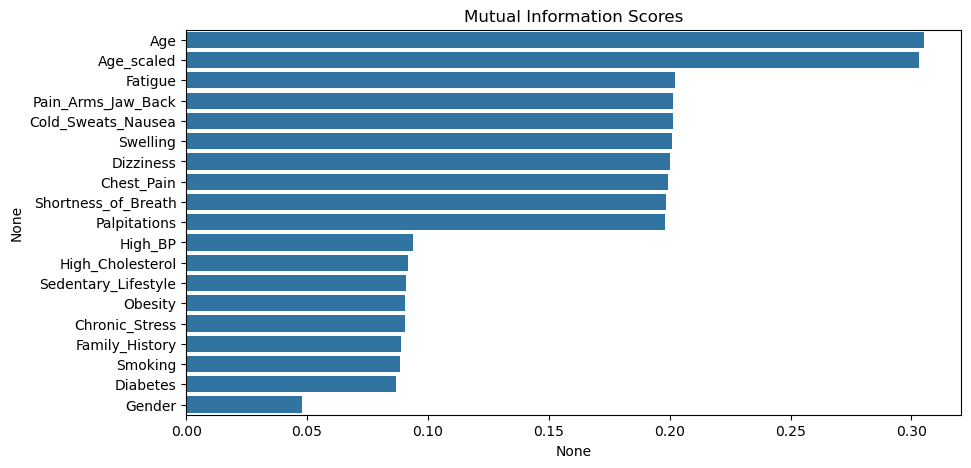

In [7]:
# Mutual information measures dependency between each feature and target
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Plot feature importance by mutual information
plt.figure(figsize=(10,5))
sns.barplot(x=mi_scores, y=mi_scores.index)
plt.title("Mutual Information Scores")
plt.show()

In [8]:
# Select top 10 features based on statistical F-test
selector = SelectKBest(score_func=f_classif, k=10)
X_kbest = selector.fit_transform(X, y)

# Get feature names that were selected
selected_features = X.columns[selector.get_support()]
print("Top 10 Features by SelectKBest:", selected_features.tolist())

Top 10 Features by SelectKBest: ['Chest_Pain', 'Shortness_of_Breath', 'Fatigue', 'Palpitations', 'Dizziness', 'Swelling', 'Pain_Arms_Jaw_Back', 'Cold_Sweats_Nausea', 'Age', 'Age_scaled']


In [9]:
# Use logistic regression model for feature selection
log_reg = LogisticRegression(max_iter=1000)

# Select top 10 features by recursively removing least important
rfe = RFE(log_reg, n_features_to_select=10)
rfe.fit(X, y)

print("Selected Features by RFE:", X.columns[rfe.support_].tolist())

Selected Features by RFE: ['Chest_Pain', 'Shortness_of_Breath', 'Fatigue', 'Palpitations', 'Dizziness', 'Swelling', 'Pain_Arms_Jaw_Back', 'Cold_Sweats_Nausea', 'Sedentary_Lifestyle', 'Age_scaled']


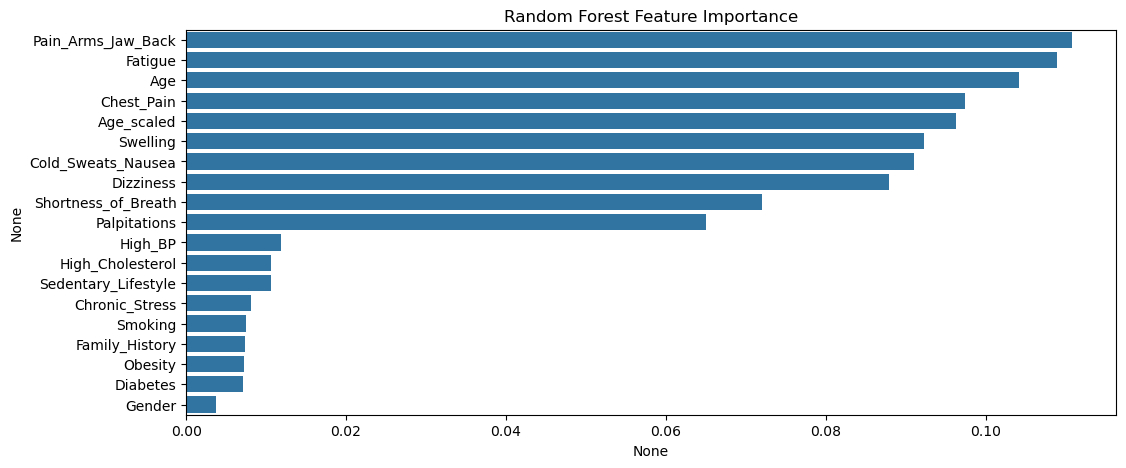

In [10]:
# Train Random Forest and check which features are most important
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Sort and plot importance scores
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12,5))
sns.barplot(x=importances, y=importances.index)
plt.title("Random Forest Feature Importance")
plt.show()

In [11]:
# -------------------------
# Select Final Features (example: Random Forest top 10)
# -------------------------
final_features = importances.head(10).index.tolist()

print("Final Selected Features:", final_features)

# Create final dataset with selected features + target
df_final = df[final_features + ['Heart_Risk']]

# Save to CSV file
df_final.to_csv("C:\\Users\\Acer\\2025-Y2-S1-MLB-B6G1-05-PGNO-105\\results\\outputs\\IT24101205_FeatureSelection.csv", index=False)

print("Final dataset saved as 'heart_disease_risk_engineered.csv'")
df_final.head()

Final Selected Features: ['Pain_Arms_Jaw_Back', 'Fatigue', 'Age', 'Chest_Pain', 'Age_scaled', 'Swelling', 'Cold_Sweats_Nausea', 'Dizziness', 'Shortness_of_Breath', 'Palpitations']
Final dataset saved as 'heart_disease_risk_engineered.csv'


,Pain_Arms_Jaw_Back,Fatigue,Age,Chest_Pain,Age_scaled,Swelling,Cold_Sweats_Nausea,Dizziness,Shortness_of_Breath,Palpitations,Heart_Risk
0,0.0,0.0,48.0,0.0,-0.393767,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,46.0,0.0,-0.515639,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,66.0,1.0,0.703080,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,60.0,1.0,0.337464,0.0,1.0,0.0,1.0,1.0,1.0
4,0.0,1.0,69.0,0.0,0.885888,0.0,0.0,1.0,0.0,0.0,0.0
